<a href="https://colab.research.google.com/github/alokraj01/Plant_disease_classification/blob/master/Plant_disease_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd

In [0]:
import numpy as np
#import pandas as pd
import os
import keras
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [0]:
import cv2
import os
from tqdm import tqdm
from tensorflow import keras
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Model,Sequential, Input, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, Callback
from keras.applications import DenseNet121

In [0]:
from keras.callbacks import Callback
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
print (os.path)

<module 'posixpath' from '/usr/lib/python3.6/posixpath.py'>


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
data_path='/content/drive/My Drive/Plant_disease/PlantVillage'

In [0]:
disease_types = ['Pepper__bell___Bacterial_spot','Pepper__bell___healthy','Potato___Early_blight','Potato___Late_blight','Potato___healthy','Tomato_Bacterial_spot','Tomato_Early_blight','Tomato_Late_blight','Tomato_Leaf_Mold','Tomato_Septoria_leaf_spot','Tomato_Spider_mites_Two_spotted_spider_mite','Tomato__Target_Spot','Tomato__Tomato_YellowLeaf__Curl_Virus','Tomato__Tomato_mosaic_virus','Tomato_healthy']
#Reducing the number of classes (Just to create a framework for faster computation)
#disease_types = ['Tomato_Bacterial_spot','Tomato_Late_blight','Tomato_Leaf_Mold','Tomato_Spider_mites_Two_spotted_spider_mite','Tomato_healthy']

In [0]:
len(disease_types)

15

In [0]:
train_data=[]
for defects_id, name in enumerate(disease_types):
    #print (defects_id)
    #print (name)
    for file in os.listdir(os.path.join(data_path,name)):
        train_data.append(['{}/{}'.format(name,file), defects_id, name])

train=pd.DataFrame(train_data,columns=['file', 'Disease_ID', 'Disease_name'])
train.head()

,file,Disease_ID,Disease_name
0,Pepper__bell___Bacterial_spot/0022d6b7-d47c-4e...,0,Pepper__bell___Bacterial_spot
1,Pepper__bell___Bacterial_spot/01940b6d-7dea-48...,0,Pepper__bell___Bacterial_spot
2,Pepper__bell___Bacterial_spot/01ebc916-4793-40...,0,Pepper__bell___Bacterial_spot
3,Pepper__bell___Bacterial_spot/01dfb88b-cd5a-42...,0,Pepper__bell___Bacterial_spot
4,Pepper__bell___Bacterial_spot/024623ab-be81-4d...,0,Pepper__bell___Bacterial_spot


In [0]:
defect_files=train['file'][train['Disease_name']=='Tomato_Bacterial_spot'].values

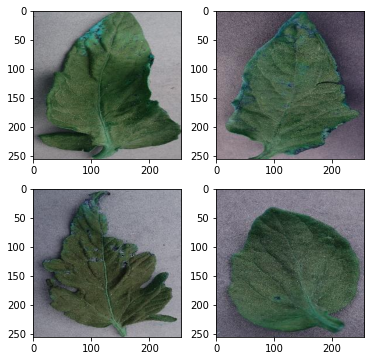

In [0]:
def plot_images(def_type, nrows, ncols):
    fig, ax = plt.subplots(nrows, nrows, figsize=(6, 6))
    defect_files=train['file'][train['Disease_name']==def_type].values
    n=0
    for i in range(nrows):
        for j in range(ncols):
            ax[i,j].imshow(cv2.imread(os.path.join(data_path,defect_files[n])))
            n=n+1
plot_images('Tomato_Bacterial_spot',2,2)

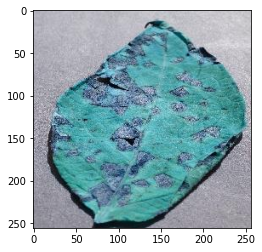

In [0]:
plt.imshow(cv2.imread('/content/drive/My Drive/Plant_disease/PlantVillage/Potato___Early_blight/042135e2-e126-4900-9212-d42d900b8125___RS_Early.B 8791.JPG'))

In [0]:
SEED=42
train_1=train.sample(frac=1.0,random_state=SEED) # Rearranging data
train_1.shape

(20647, 3)

In [0]:
train_1.index=np.arange(len(train_1))

<Figure size 864x864 with 0 Axes>

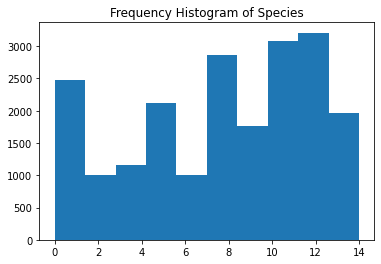

<Figure size 864x864 with 0 Axes>

In [0]:
#train_1.groupby('Disease_ID').count()
#Histogram
plt.hist(train['Disease_ID'])
plt.title('Frequency Histogram of Species')
plt.figure(figsize=(12, 12))

In [0]:
def read_image(filepath):
    image=cv2.imread(os.path.join(data_path,filepath))
    return image
def resize_image(image,image_size):
    return cv2.resize(image.copy(),image_size, interpolation=cv2.INTER_AREA)

In [0]:
image_size=64
#print (train_1[0])
X_data=np.zeros((train_1.shape[0],image_size,image_size,3))
for i, file in tqdm(enumerate(train_1['file'].values)):
    image=read_image(file)
    if image is not None:
        X_data[i]=resize_image(image,(image_size,image_size))
    #print (i)
    #print (file)
X_data=X_data/255.
print ('Data shape = {}'.format(X_data.shape))

20647it [1:35:42,  3.60it/s]


Data shape = (20647, 64, 64, 3)


In [0]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10414801364855995918
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 8818171153614085231
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 8395822880652719771
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7304675328
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2056677161558831869
physical_device_desc: "device: 0, name: Tesla P4, pci bus id: 0000:00:04.0, compute capability: 6.1"
]


In [0]:
y_data=train_1['Disease_ID'].values
print (y_data.shape)
y_data=to_categorical(y_data,num_classes=15)
print (y_data.shape)

(20647,)
(20647, 15)


Total Images in dataset is 20647. This will be split into training, validation and test dataset. There are of 15 classes.

In [0]:
# Split the train and validation sets 
#X_train, X_val, Y_train, Y_val = train_test_split(X_data, y_data, test_size=0.2, random_state=SEED)
X_train, X_test, Y_train, Y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=SEED)

X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=SEED) # 0.25 x 0.8 = 0.2

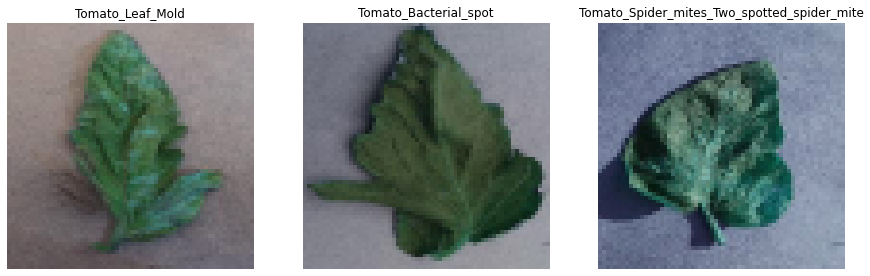

In [0]:
fig, ax = plt.subplots(1, 3, figsize=(15, 15))
for i in range(3):
    ax[i].set_axis_off()
    ax[i].imshow(X_train[i])
    ax[i].set_title(disease_types[np.argmax(Y_train[i])])

Starting with a simple Artificial neural network and its performance

In [0]:
#Normal neural network (without CNN)
from time import time
model_1=keras.models.Sequential([
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(15, activation='softmax')
])
model_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
t0 = time()
model_1.fit(X_train,Y_train, epochs=20)
print ("training time: ", round(time()-t0, 3), "s")
model_1.evaluate(X_val,Y_val)

Epoch 1/20
413/413 [==============================] - 2s 4ms/step - loss: 2.2259 - accuracy: 0.3525
Epoch 2/20
413/413 [==============================] - 2s 4ms/step - loss: 1.5553 - accuracy: 0.5063
Epoch 3/20
413/413 [==============================] - 2s 4ms/step - loss: 1.3246 - accuracy: 0.5771
Epoch 4/20
413/413 [==============================] - 2s 4ms/step - loss: 1.1990 - accuracy: 0.6133
Epoch 5/20
413/413 [==============================] - 2s 4ms/step - loss: 1.0966 - accuracy: 0.6425
Epoch 6/20
413/413 [==============================] - 2s 4ms/step - loss: 1.0608 - accuracy: 0.6484
Epoch 7/20
413/413 [==============================] - 2s 4ms/step - loss: 1.0080 - accuracy: 0.6645
Epoch 8/20
413/413 [==============================] - 2s 4ms/step - loss: 0.8990 - accuracy: 0.7016
Epoch 9/20
413/413 [==============================] - 2s 4ms/step - loss: 0.8789 - accuracy: 0.7026
Epoch 10/20
413/413 [==============================] - 2s 4ms/step - loss: 0.8182 - accuracy: 0.7289

[0.7411631941795349, 0.7515133023262024]

Accuracy of around 80% on training data and around 75% on validation.
Already a decent accuracy for a simple NN. 

In [0]:
#Add some regularizarion like batchnorm and dropout
#Normal neural network (without CNN)
model_1_reg=keras.models.Sequential([
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.BatchNormalization(),
    #keras.layers.Dropout(0.1),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.BatchNormalization(),
    #keras.layers.Dropout(0.1),
    keras.layers.Dense(15, activation='softmax')
])
model_1_reg.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
t0 = time()
model_1_reg.fit(X_train,Y_train, epochs=20)
print ("training time: ", round(time()-t0, 3), "s")
model_1_reg.evaluate(X_val,Y_val)

Epoch 1/20
413/413 [==============================] - 2s 5ms/step - loss: 1.3218 - accuracy: 0.5974
Epoch 2/20
413/413 [==============================] - 2s 5ms/step - loss: 0.8905 - accuracy: 0.7204
Epoch 3/20
413/413 [==============================] - 2s 5ms/step - loss: 0.7407 - accuracy: 0.7642
Epoch 4/20
413/413 [==============================] - 2s 5ms/step - loss: 0.6365 - accuracy: 0.7911
Epoch 5/20
413/413 [==============================] - 2s 5ms/step - loss: 0.5508 - accuracy: 0.8188
Epoch 6/20
413/413 [==============================] - 2s 5ms/step - loss: 0.5133 - accuracy: 0.8332
Epoch 7/20
413/413 [==============================] - 2s 5ms/step - loss: 0.4789 - accuracy: 0.8432
Epoch 8/20
413/413 [==============================] - 2s 5ms/step - loss: 0.4594 - accuracy: 0.8447
Epoch 9/20
413/413 [==============================] - 2s 5ms/step - loss: 0.4250 - accuracy: 0.8573
Epoch 10/20
413/413 [==============================] - 2s 5ms/step - loss: 0.4074 - accuracy: 0.8658

[1.586464762687683, 0.626210629940033]

Implementing Transfer learning to initiate weights of DenseNet121 trained on "imagenet" dataset

In [0]:
Model_2 = DenseNet121(weights='imagenet', include_top=False)
input = Input(shape=(64, 64,3))
x = Conv2D(3, (3, 3), padding='same')(input)
    
x = Model_2(x)
    
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

output = Dense(15,activation = 'softmax', name='root')(x)
 

# model
#model = Model(input,output)

29089792/29084464 [==============================] - 0s 0us/step


In [0]:
Model_2_without_BN = DenseNet121(weights='imagenet', include_top=False)
input = Input(shape=(64, 64,3))
x = Conv2D(3, (3, 3), padding='same')(input)
    
x = Model_2(x)
    
x = GlobalAveragePooling2D()(x)
#x = BatchNormalization()(x)
#x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
#x = BatchNormalization()(x)
#x = Dropout(0.5)(x)
    # multi output
output = Dense(15,activation = 'softmax', name='root')(x)
for layer in Model_2_without_BN.layers:
    #layer.trainable = False
    layer.trainable = True
Model_2_without_BN = Model(input,output)
Model_2_without_BN.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 3)         84        
_________________________________________________________________
densenet121 (Model)          multiple                  7037504   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               262400    
_________________________________________________________________
root (Dense)                 (None, 15)                3855      
Total params: 7,303,843
Trainable params: 7,220,195
Non-trainable params: 83,648
____________________________________________

In [0]:
for layer in Model_2.layers:
    #layer.trainable = False
    layer.trainable = True
model_2 = Model(input,output)
model_2.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 3)         84        
_________________________________________________________________
densenet121 (Model)          multiple                  7037504   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 1024)              4096      
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2624

In [0]:
model_5.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_5.fit(X_train,Y_train, epochs=15)
model_5.evaluate(X_val,Y_val)

Epoch 1/15
13213/13213 [==============================] - 132s 10ms/step - loss: 0.9980 - accuracy: 0.7046
Epoch 2/15
13213/13213 [==============================] - 88s 7ms/step - loss: 0.3443 - accuracy: 0.8888
Epoch 3/15
13213/13213 [==============================] - 89s 7ms/step - loss: 0.2230 - accuracy: 0.9290
Epoch 4/15
13213/13213 [==============================] - 90s 7ms/step - loss: 0.1940 - accuracy: 0.9392
Epoch 5/15
13213/13213 [==============================] - 89s 7ms/step - loss: 0.1772 - accuracy: 0.9431
Epoch 6/15
13213/13213 [==============================] - 89s 7ms/step - loss: 0.1393 - accuracy: 0.9550
Epoch 7/15
13213/13213 [==============================] - 89s 7ms/step - loss: 0.1383 - accuracy: 0.9563
Epoch 8/15
13213/13213 [==============================] - 89s 7ms/step - loss: 0.1284 - accuracy: 0.9578
Epoch 9/15
13213/13213 [==============================] - 89s 7ms/step - loss: 0.1145 - accuracy: 0.9620
Epoch 10/15
13213/13213 [============================

[0.2340475396674857, 0.9282687902450562]

Validation accuracy for DenseNet121 is 92.8%

In [0]:
Model_5_without_BN.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
Model_5_without_BN.fit(X_train,Y_train, epochs=15)
Model_5_without_BN.evaluate(X_val,Y_val)

Epoch 1/15
13213/13213 [==============================] - 126s 10ms/step - loss: 0.3876 - accuracy: 0.8786
Epoch 2/15
13213/13213 [==============================] - 89s 7ms/step - loss: 0.1326 - accuracy: 0.9580
Epoch 3/15
13213/13213 [==============================] - 89s 7ms/step - loss: 0.1139 - accuracy: 0.9628
Epoch 4/15
13213/13213 [==============================] - 88s 7ms/step - loss: 0.0807 - accuracy: 0.9759
Epoch 5/15
13213/13213 [==============================] - 88s 7ms/step - loss: 0.0836 - accuracy: 0.9742
Epoch 6/15
13213/13213 [==============================] - 88s 7ms/step - loss: 0.0824 - accuracy: 0.9726
Epoch 7/15
13213/13213 [==============================] - 87s 7ms/step - loss: 0.0730 - accuracy: 0.9771
Epoch 8/15
13213/13213 [==============================] - 86s 7ms/step - loss: 0.0630 - accuracy: 0.9821
Epoch 9/15
13213/13213 [==============================] - 86s 7ms/step - loss: 0.0434 - accuracy: 0.9849
Epoch 10/15
13213/13213 [============================

[0.698711466837954, 0.856840193271637]

In [0]:
#GPU count and name
!nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-5a9540cd-bb33-1196-448a-3d253c0fe3b0)


In [0]:
#A simple and small CNN network
model_2= Sequential([
    Conv2D(64,(3,3), activation='relu', input_shape=(64,64,3)),
    MaxPool2D(2,2),
    Conv2D(32,(3,3), activation='relu'),
    MaxPool2D(2,2),
    Conv2D(16,(3,3), activation='relu'),
    MaxPool2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(15, activation='softmax')
])
model_2.summary()
model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_2.fit(X_train,Y_train, epochs=15)
model_2.evaluate(X_val,Y_val)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 62, 62, 64)        1792      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 29, 29, 32)        18464     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 12, 12, 16)        4624      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 6, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 576)              

[0.4019896123946146, 0.8816586136817932]

In [0]:
#A simple CNN with batchnorm
model_2_reg= Sequential([
    Conv2D(64,(3,3), activation='relu', input_shape=(64,64,3)),
    MaxPool2D(2,2),
    BatchNormalization(),
    #Dropout(0.2),
    Conv2D(32,(3,3), activation='relu'),
    MaxPool2D(2,2),
    BatchNormalization(),
    #Dropout(0.2),
    Conv2D(16,(3,3), activation='relu'),
    MaxPool2D(2,2),
    BatchNormalization(),
    #Dropout(0.2),
    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    #Dropout(0.2),
    Dense(15, activation='softmax')
])
model_2_reg.summary()
model_2_reg.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_2_reg.fit(X_train,Y_train, epochs=15)
model_2_reg.evaluate(X_val,Y_val)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 62, 62, 64)        1792      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 31, 31, 64)        0         
_________________________________________________________________
batch_normalization_15 (Batc (None, 31, 31, 64)        256       
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 29, 29, 32)        18464     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
batch_normalization_16 (Batc (None, 14, 14, 32)        128       
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 12, 12, 16)       

[0.5208514506678316, 0.8586561679840088]

In [0]:
#A simple CNN
model_3= Sequential([
    Conv2D(128,(3,3), activation='relu', input_shape=(64,64,3)),
    MaxPool2D(2,2),
    Conv2D(64,(3,3), activation='relu', input_shape=(64,64,3)),
    MaxPool2D(2,2),
    Conv2D(32,(3,3), activation='relu'),
    MaxPool2D(2,2),
    Conv2D(16,(3,3), activation='relu'),
    MaxPool2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(15, activation='softmax')
])
model_3.summary()
model_3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_3.fit(X_train,Y_train, epochs=15)
model_3.evaluate(X_val,Y_val)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 62, 62, 128)       3584      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 31, 31, 128)       0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 29, 29, 64)        73792     
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 12, 12, 32)        18464     
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 6, 6, 32)          0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 4, 4, 16)         

[0.4611622024390657, 0.8486682772636414]

In [0]:
#A simple CNN
model_3_reg= Sequential([
    Conv2D(128,(3,3), activation='relu', input_shape=(64,64,3)),
    MaxPool2D(2,2),
    BatchNormalization(),
    Conv2D(64,(3,3), activation='relu', input_shape=(64,64,3)),
    MaxPool2D(2,2),
    BatchNormalization(),
    Conv2D(32,(3,3), activation='relu'),
    MaxPool2D(2,2),
    BatchNormalization(),
    Conv2D(16,(3,3), activation='relu'),
    MaxPool2D(2,2),
    BatchNormalization(),
    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dense(15, activation='softmax')
])
model_3_reg.summary()
model_3_reg.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_3_reg.fit(X_train,Y_train, epochs=15)
model_3_reg.evaluate(X_val,Y_val)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 62, 62, 128)       3584      
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 31, 31, 128)       0         
_________________________________________________________________
batch_normalization_19 (Batc (None, 31, 31, 128)       512       
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 29, 29, 64)        73792     
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
batch_normalization_20 (Batc (None, 14, 14, 64)        256       
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 12, 12, 32)       

[0.6896384948679668, 0.8156779408454895]

Very Simple CNN already achieves an accuracy of about 80-85% on validation dataset

Implementation of ReduceLROnPlateau to optimise learning rate, checkpoint to save the best model (which could be imported later) and callbacks to target desired accuracy

In [0]:
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',factor=0.5,min_lr=0.001,patience=5,verbose=1)
checkpoint = ModelCheckpoint('/content/drive/My Drive/Plant_disease/model_2_reg.h5',verbose=1,save_best_only=True)
class mycallback(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs= {}):
    if (logs.get('val_accuracy')>0.8):
      print ('\nReached 80% accuracy. So canceling the run')
      self.model.stop_training = True

datagen = ImageDataGenerator(rotation_range=360,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             vertical_flip=True)
callbacks=mycallback()
datagen.fit(X_train)
hist = model_2_reg.fit_generator(datagen.flow(X_train, Y_train, batch_size=64),
               steps_per_epoch=X_train.shape[0] // 64,
               epochs=20,
               verbose=2,
               callbacks=[callbacks,reduce_lr, checkpoint],
               validation_data=(X_val, Y_val))
#ModelCheckpoint()
#model_2_reg.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#model_2_reg.fit(X_train,Y_train, epochs=15)
#model_2_reg.evaluate(X_val,Y_val)

Epoch 1/20
 - 4s - loss: 0.8362 - accuracy: 0.7562 - val_loss: 5.4478 - val_accuracy: 0.2995

Epoch 00001: val_loss improved from inf to 5.44782, saving model to /content/drive/My Drive/Plant_disease/model_2_reg.h5
Epoch 2/20
 - 4s - loss: 0.3965 - accuracy: 0.8481 - val_loss: 6.8865 - val_accuracy: 0.2920

Epoch 00002: val_loss did not improve from 5.44782
Epoch 3/20
 - 4s - loss: 0.3692 - accuracy: 0.8632 - val_loss: 0.3619 - val_accuracy: 0.8533

Reached 80% accuracy. So canceling the run

Epoch 00003: val_loss improved from 5.44782 to 0.36193, saving model to /content/drive/My Drive/Plant_disease/model_2_reg.h5


In [0]:
#A simple yet better CNN without batchnorm
#Number of filters increasing and maxpooling reducing the width and height dimension

model_4= Sequential([
    Conv2D(64,(3,3), activation='relu', input_shape=(64,64,3)),
    MaxPool2D(2,2),
    #BatchNormalization(),
    Conv2D(128,(3,3), activation='relu'),
    MaxPool2D(2,2),
    #BatchNormalization(),
    Conv2D(256,(3,3), activation='relu'),
    MaxPool2D(2,2),
    Flatten(),
    #Dense(2048, activation='relu'),
    Dense(1024, activation='relu'),
    Dense(128, activation='relu'),
    Dense(15, activation='softmax')
])
model_4.summary()
model_4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#t0=time()
#model_4.fit(X_train,Y_train, epochs=15)
#print ("Training time: ", round((time()-t0),3))
#model_4.evaluate(X_val,Y_val)

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_72 (Conv2D)           (None, 62, 62, 64)        1792      
_________________________________________________________________
max_pooling2d_70 (MaxPooling (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_73 (Conv2D)           (None, 29, 29, 128)       73856     
_________________________________________________________________
max_pooling2d_71 (MaxPooling (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_74 (Conv2D)           (None, 12, 12, 256)       295168    
_________________________________________________________________
max_pooling2d_72 (MaxPooling (None, 6, 6, 256)         0         
_________________________________________________________________
flatten_23 (Flatten)         (None, 9216)            

Checking the performance on validation and test dataset after every epochs

In [0]:
class TestCallback(Callback):
    def __init__(self, test_data):
        self.test_data = test_data

    def on_epoch_end(self, epoch, logs={}):
        x, y = self.test_data
        loss, acc = self.model.evaluate(x, y, verbose=0)
        print('\nTesting loss: {}, acc: {}\n'.format(loss, acc))
model_4.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=10, 
          callbacks=[TestCallback((X_test, Y_test))])


Train on 13213 samples, validate on 3304 samples
Epoch 1/10
13213/13213 [==============================] - 11s 855us/step - loss: 1.5407 - accuracy: 0.5025 - val_loss: 1.0187 - val_accuracy: 0.6665

Testing loss: 1.0474395958621046, acc: 0.662469744682312

Epoch 2/10
13213/13213 [==============================] - 11s 836us/step - loss: 0.6700 - accuracy: 0.7733 - val_loss: 0.5227 - val_accuracy: 0.8123

Testing loss: 0.5416652037502778, acc: 0.8152542114257812

Epoch 3/10
13213/13213 [==============================] - 11s 842us/step - loss: 0.4196 - accuracy: 0.8544 - val_loss: 0.3892 - val_accuracy: 0.8659

Testing loss: 0.398236515547981, acc: 0.8757869005203247

Epoch 4/10
13213/13213 [==============================] - 11s 840us/step - loss: 0.2876 - accuracy: 0.8998 - val_loss: 0.3320 - val_accuracy: 0.8841

Testing loss: 0.354853370028027, acc: 0.8953995108604431

Epoch 5/10
13213/13213 [==============================] - 11s 837us/step - loss: 0.2008 - accuracy: 0.9306 - val_loss:

In [0]:
#A simple yet better CNN with batchnorm/ dropout
model_4_reg= Sequential([
    Conv2D(64,(3,3), activation='relu', input_shape=(64,64,3)),
    MaxPool2D(2,2),
    #BatchNormalization(),
    Dropout(0.2),
    Conv2D(128,(3,3), activation='relu'),
    MaxPool2D(2,2),
    #BatchNormalization(),
    Dropout(0.2),
    Conv2D(256,(3,3), activation='relu'),
    MaxPool2D(2,2),
    #BatchNormalization(),
    Dropout(0.2),
    Flatten(),
    #Dense(2048, activation='relu'),
    #BatchNormalization(),
    #Dropout(0.2),
    Dense(1024, activation='relu'),
    #BatchNormalization(),
    Dropout(0.2),
    Dense(128, activation='relu'),
    #BatchNormalization(),
    Dropout(0.2),
    Dense(15, activation='softmax')
])
model_4_reg.summary()
model_4_reg.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#t0=time()
#model_4_reg.fit(X_train,Y_train, epochs=15)
#print ("Training time: ", round((time()-t0),3))
#model_4_reg.evaluate(X_val,Y_val)

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_75 (Conv2D)           (None, 62, 62, 64)        1792      
_________________________________________________________________
max_pooling2d_73 (MaxPooling (None, 31, 31, 64)        0         
_________________________________________________________________
dropout_39 (Dropout)         (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_76 (Conv2D)           (None, 29, 29, 128)       73856     
_________________________________________________________________
max_pooling2d_74 (MaxPooling (None, 14, 14, 128)       0         
_________________________________________________________________
dropout_40 (Dropout)         (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_77 (Conv2D)           (None, 12, 12, 256)     

In [0]:
class TestCallback(Callback):
    def __init__(self, test_data):
        self.test_data = test_data

    def on_epoch_end(self, epoch, logs={}):
        x, y = self.test_data
        loss, acc = self.model.evaluate(x, y, verbose=0)
        print('\nTesting loss: {}, acc: {}\n'.format(loss, acc))
hist_model_4=model_4_reg.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=10, 
          callbacks=[TestCallback((X_test, Y_test))])

Train on 13213 samples, validate on 3304 samples
Epoch 1/10
13213/13213 [==============================] - 12s 940us/step - loss: 1.8336 - accuracy: 0.4070 - val_loss: 1.0650 - val_accuracy: 0.6613

Testing loss: 1.078116375943939, acc: 0.67215496301651

Epoch 2/10
13213/13213 [==============================] - 12s 916us/step - loss: 0.8678 - accuracy: 0.7138 - val_loss: 0.6952 - val_accuracy: 0.7582

Testing loss: 0.7023623785441493, acc: 0.7728813290596008

Epoch 3/10
13213/13213 [==============================] - 12s 915us/step - loss: 0.5852 - accuracy: 0.8036 - val_loss: 0.4869 - val_accuracy: 0.8284

Testing loss: 0.5229828721818854, acc: 0.832929790019989

Epoch 4/10
13213/13213 [==============================] - 12s 921us/step - loss: 0.4627 - accuracy: 0.8477 - val_loss: 0.3590 - val_accuracy: 0.8735

Testing loss: 0.37930963354018354, acc: 0.8748183846473694

Epoch 5/10
13213/13213 [==============================] - 12s 921us/step - loss: 0.3615 - accuracy: 0.8756 - val_loss:

Best validation accuracy is 92.3% 

In [0]:
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',factor=0.5,min_lr=0.001,patience=5,verbose=1)
checkpoint = ModelCheckpoint('/content/drive/My Drive/Plant_disease/model_4_reg.h5',verbose=1,save_best_only=True)
class mycallback(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs= {}):
    if (logs.get('val_accuracy')>0.95):
      print ('\nReached 95% accuracy. So canceling the run')
      self.model.stop_training = True

#datagen = ImageDataGenerator(rotation_range=360,
#                             width_shift_range=0.2,
#                             height_shift_range=0.2,
#                             zoom_range=0.2,
#                             horizontal_flip=True,
#                             vertical_flip=True)
callbacks=mycallback()
#datagen.fit(X_train)
#hist = model_resnet.fit_generator(datagen.flow(X_train, Y_train, batch_size=64),
t0=time()
hist_model_4_reg = model_4_reg.fit(X_train, Y_train, #batch_size=64,
               #steps_per_epoch=X_train.shape[0] // 64,
               epochs=20,
               verbose=2,
               callbacks=[callbacks,reduce_lr, checkpoint],
               validation_data=(X_val, Y_val),validation_steps=None)
print ("Training time: ", round((time()-t0),3))
#ModelCheckpoint()
#model_2_reg.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#model_2_reg.fit(X_train,Y_train, epochs=15)
#model_2_reg.evaluate(X_val,Y_val)

Train on 13213 samples, validate on 3304 samples
Epoch 1/20
 - 12s - loss: 1.6905 - accuracy: 0.4496 - val_loss: 0.9418 - val_accuracy: 0.6949

Epoch 00001: val_loss improved from inf to 0.94183, saving model to /content/drive/My Drive/Plant_disease/model_4_reg.h5
Epoch 2/20
 - 12s - loss: 0.8256 - accuracy: 0.7281 - val_loss: 0.5579 - val_accuracy: 0.8084

Epoch 00002: val_loss improved from 0.94183 to 0.55785, saving model to /content/drive/My Drive/Plant_disease/model_4_reg.h5
Epoch 3/20
 - 12s - loss: 0.5535 - accuracy: 0.8153 - val_loss: 0.4384 - val_accuracy: 0.8529

Epoch 00003: val_loss improved from 0.55785 to 0.43837, saving model to /content/drive/My Drive/Plant_disease/model_4_reg.h5
Epoch 4/20
 - 12s - loss: 0.4246 - accuracy: 0.8555 - val_loss: 0.3388 - val_accuracy: 0.8811

Epoch 00004: val_loss improved from 0.43837 to 0.33879, saving model to /content/drive/My Drive/Plant_disease/model_4_reg.h5
Epoch 5/20
 - 12s - loss: 0.3396 - accuracy: 0.8875 - val_loss: 0.4090 - va

Validation accuracy improved to 93.13% with learning rate optimisation.
I also tried using ImageDatagenerator to increase number of image. However, it reduced the accuracy. It could be because zoom or shift of training set could have created some confusing image for algorithm which could make it difficult to train. So, I removed it.

Trying out another pre-trained weights. I liked the concept of ResNet. So, initialising with its weights

In [0]:
from keras.applications.resnet50 import ResNet50

In [0]:
Model_resnet = ResNet50(weights='imagenet', include_top=False)
input = Input(shape=(64, 64,3))
x = Conv2D(3, (3, 3), padding='same')(input)
    
x = Model_5(x)
    
x = GlobalAveragePooling2D()(x)
#x = BatchNormalization()(x)
#x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
#x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
#x = BatchNormalization()(x)
#x = Dropout(0.5)(x)
    # multi output
output = Dense(15,activation = 'softmax', name='root')(x)

 3342336/94653016 [>.............................] - ETA: 1s 

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 1s 0us/step


In [0]:
model_resnet = Model(input,output)
model_resnet.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 64, 64, 3)         84        
_________________________________________________________________
densenet121 (Model)          multiple                  7037504   
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1024)              0         
_________________________________________________________________
dense_53 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_54 (Dense)             (None, 256)               131328    
_________________________________________________________________
root (Dense)                 (None, 15)                3855

In [0]:
model_resnet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
t0=time()
model_resnet.fit(X_train,Y_train, epochs=15)
print ("Training time: ", round((time()-t0),3))
model_resnet.evaluate(X_val,Y_val)

Epoch 1/15
13213/13213 [==============================] - 121s 9ms/step - loss: 0.3450 - accuracy: 0.8902
Epoch 2/15
13213/13213 [==============================] - 87s 7ms/step - loss: 0.0688 - accuracy: 0.9804
Epoch 3/15
13213/13213 [==============================] - 85s 6ms/step - loss: 0.0628 - accuracy: 0.9809
Epoch 4/15
13213/13213 [==============================] - 85s 6ms/step - loss: 0.0697 - accuracy: 0.9808
Epoch 5/15
13213/13213 [==============================] - 84s 6ms/step - loss: 0.0625 - accuracy: 0.9831
Epoch 6/15
13213/13213 [==============================] - 84s 6ms/step - loss: 0.0842 - accuracy: 0.9772
Epoch 7/15
13213/13213 [==============================] - 85s 6ms/step - loss: 0.0726 - accuracy: 0.9792
Epoch 8/15
13213/13213 [==============================] - 85s 6ms/step - loss: 0.0445 - accuracy: 0.9877
Epoch 9/15
13213/13213 [==============================] - 84s 6ms/step - loss: 0.0366 - accuracy: 0.9899
Epoch 10/15
13213/13213 [=============================

[0.9434692755738413, 0.7890436053276062]

In [0]:
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',factor=0.5,min_lr=0.001,patience=5,verbose=1)
checkpoint = ModelCheckpoint('/content/drive/My Drive/Plant_disease/model_resnet.h5',verbose=1,save_best_only=True)
class mycallback(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs= {}):
    if (logs.get('val_accuracy')>0.98):
      print ('\nReached 95% accuracy. So canceling the run')
      self.model.stop_training = True

datagen = ImageDataGenerator(rotation_range=360,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             vertical_flip=True)
callbacks=mycallback()
datagen.fit(X_train)
hist = model_resnet.fit_generator(datagen.flow(X_train, Y_train, batch_size=64),
               steps_per_epoch=X_train.shape[0] // 64,
               epochs=20,
               verbose=2,
               callbacks=[callbacks,reduce_lr, checkpoint],
               validation_data=(X_val, Y_val))
#ModelCheckpoint()
#model_2_reg.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#model_2_reg.fit(X_train,Y_train, epochs=15)
#model_2_reg.evaluate(X_val,Y_val)

Epoch 1/20
 - 68s - loss: 0.1427 - accuracy: 0.9527 - val_loss: 0.1545 - val_accuracy: 0.9543

Epoch 00001: val_loss improved from inf to 0.15446, saving model to /content/drive/My Drive/Plant_disease/model_resnet.h5
Epoch 2/20
 - 67s - loss: 0.1172 - accuracy: 0.9614 - val_loss: 0.2235 - val_accuracy: 0.9364

Epoch 00002: val_loss did not improve from 0.15446
Epoch 3/20
 - 67s - loss: 0.1049 - accuracy: 0.9636 - val_loss: 0.6323 - val_accuracy: 0.8296

Epoch 00003: val_loss did not improve from 0.15446
Epoch 4/20
 - 66s - loss: 0.1013 - accuracy: 0.9657 - val_loss: 0.0920 - val_accuracy: 0.9688

Epoch 00004: val_loss improved from 0.15446 to 0.09197, saving model to /content/drive/My Drive/Plant_disease/model_resnet.h5
Epoch 5/20
 - 67s - loss: 0.1028 - accuracy: 0.9659 - val_loss: 0.3331 - val_accuracy: 0.9044

Epoch 00005: val_loss did not improve from 0.09197
Epoch 6/20
 - 67s - loss: 0.0925 - accuracy: 0.9695 - val_loss: 0.3466 - val_accuracy: 0.9050

Epoch 00006: val_loss did not

Best Validation accuracy was found to be 96%

Saving the best custom model

In [0]:
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',factor=0.5,min_lr=0.001,patience=5,verbose=1)
checkpoint = ModelCheckpoint('/content/drive/My Drive/Plant_disease/model_4_reg.h5',verbose=1,save_best_only=True)
class mycallback(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs= {}):
    if (logs.get('val_accuracy')>0.96):
      print ('\nReached 96% accuracy. So canceling the run')
      self.model.stop_training = True

datagen = ImageDataGenerator(rotation_range=360,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             vertical_flip=True)
callbacks=mycallback()
datagen.fit(X_train)
hist = model_4_reg.fit_generator(datagen.flow(X_train, Y_train, batch_size=64),
               steps_per_epoch=X_train.shape[0] // 64,
               epochs=20,
               verbose=2,
               callbacks=[callbacks,reduce_lr, checkpoint],
               validation_data=(X_val, Y_val))
#ModelCheckpoint()
#model_2_reg.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#model_2_reg.fit(X_train,Y_train, epochs=15)
#model_2_reg.evaluate(X_val,Y_val)

Epoch 1/20
 - 16s - loss: 0.9033 - accuracy: 0.7185 - val_loss: 0.3009 - val_accuracy: 0.8959

Epoch 00001: val_loss improved from inf to 0.30095, saving model to /content/drive/My Drive/Plant_disease/model_4_reg.h5
Epoch 2/20
 - 16s - loss: 0.6335 - accuracy: 0.7940 - val_loss: 0.4647 - val_accuracy: 0.8487

Epoch 00002: val_loss did not improve from 0.30095
Epoch 3/20
 - 16s - loss: 0.5825 - accuracy: 0.8062 - val_loss: 0.3460 - val_accuracy: 0.8823

Epoch 00003: val_loss did not improve from 0.30095
Epoch 4/20
 - 16s - loss: 0.5181 - accuracy: 0.8253 - val_loss: 0.3150 - val_accuracy: 0.8953

Epoch 00004: val_loss did not improve from 0.30095
Epoch 5/20
 - 16s - loss: 0.4823 - accuracy: 0.8362 - val_loss: 0.2690 - val_accuracy: 0.9119

Epoch 00005: val_loss improved from 0.30095 to 0.26897, saving model to /content/drive/My Drive/Plant_disease/model_4_reg.h5
Epoch 6/20
 - 16s - loss: 0.4591 - accuracy: 0.8418 - val_loss: 0.3107 - val_accuracy: 0.8953

Epoch 00006: val_loss did not i

Best Validation accuracy came out to be 94% which is extremely good. Run time is significantly lower than that for pre-trained weights

In [0]:
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',factor=0.5,min_lr=0.001,patience=5,verbose=1)
checkpoint = ModelCheckpoint('/content/drive/My Drive/Plant_disease/model_4.h5',verbose=1,save_best_only=True)
class mycallback(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs= {}):
    if (logs.get('val_accuracy')>0.96):
      print ('\nReached 96% accuracy. So canceling the run')
      self.model.stop_training = True

datagen = ImageDataGenerator(rotation_range=360,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             vertical_flip=True)
callbacks=mycallback()
datagen.fit(X_train)
hist = model_4.fit_generator(datagen.flow(X_train, Y_train, batch_size=64),
               steps_per_epoch=X_train.shape[0] // 64,
               epochs=20,
               verbose=2,
               callbacks=[callbacks,reduce_lr, checkpoint],
               validation_data=(X_val, Y_val))
#ModelCheckpoint()
#model_2_reg.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#model_2_reg.fit(X_train,Y_train, epochs=15)
#model_2_reg.evaluate(X_val,Y_val)

Epoch 1/20
 - 16s - loss: 0.8943 - accuracy: 0.7217 - val_loss: 0.3754 - val_accuracy: 0.8759

Epoch 00001: val_loss improved from inf to 0.37536, saving model to /content/drive/My Drive/Plant_disease/model_4.h5
Epoch 2/20
 - 16s - loss: 0.5830 - accuracy: 0.8004 - val_loss: 0.3172 - val_accuracy: 0.8913

Epoch 00002: val_loss improved from 0.37536 to 0.31717, saving model to /content/drive/My Drive/Plant_disease/model_4.h5
Epoch 3/20
 - 16s - loss: 0.4501 - accuracy: 0.8433 - val_loss: 0.2852 - val_accuracy: 0.9038

Epoch 00003: val_loss improved from 0.31717 to 0.28517, saving model to /content/drive/My Drive/Plant_disease/model_4.h5
Epoch 4/20
 - 16s - loss: 0.3919 - accuracy: 0.8644 - val_loss: 0.2641 - val_accuracy: 0.9077

Epoch 00004: val_loss improved from 0.28517 to 0.26411, saving model to /content/drive/My Drive/Plant_disease/model_4.h5
Epoch 5/20
 - 16s - loss: 0.3364 - accuracy: 0.8815 - val_loss: 0.2588 - val_accuracy: 0.9150

Epoch 00005: val_loss improved from 0.26411 t

Validation accuracy improved to 95%

Text(0.5, 144.41374999999996, 'Predicted')

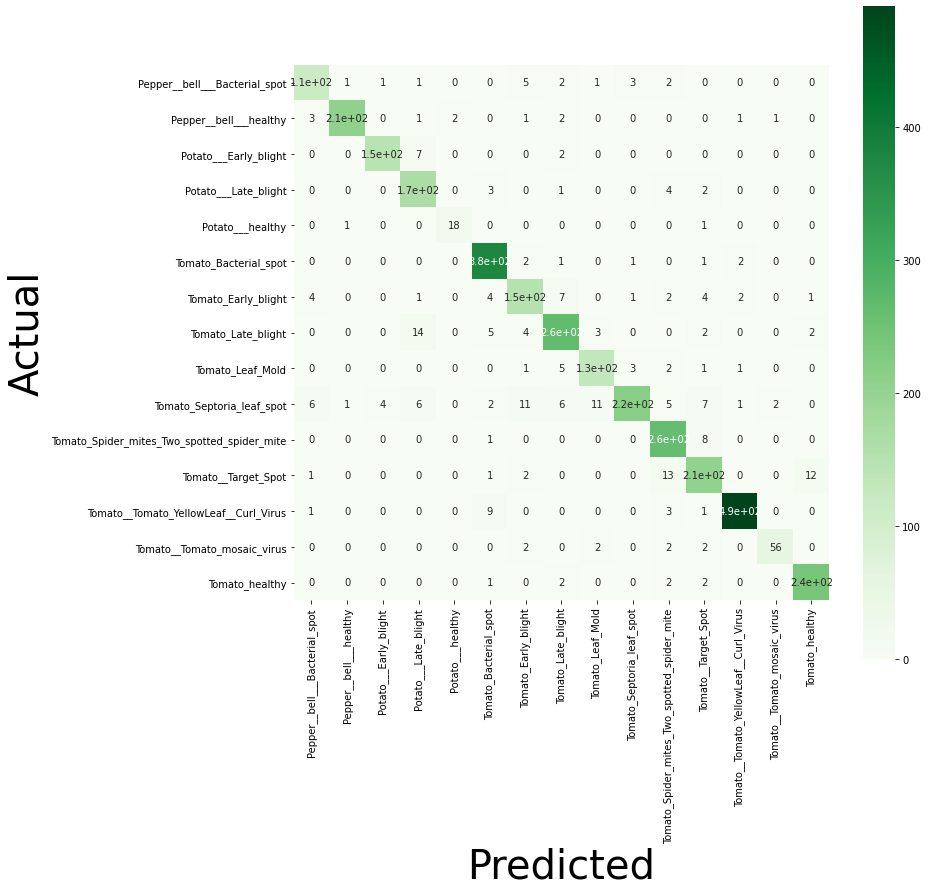

In [0]:
Y_pred = model_4_reg.predict(X_val)

Y_pred = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_val, axis=1)
#print (Y_pred)
cm = confusion_matrix(Y_true, Y_pred)
plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, cmap=plt.cm.Greens, annot=True, square=True, xticklabels=disease_types, yticklabels=disease_types)
ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)

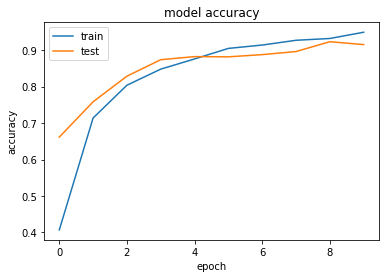

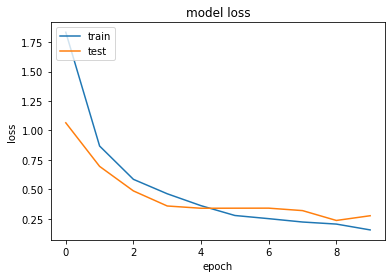

In [0]:
# accuracy plot 
plt.plot(hist_model_4.history['accuracy'])
plt.plot(hist_model_4.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# loss plot
plt.plot(hist_model_4.history['loss'])
plt.plot(hist_model_4.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

We can use the model saved earlier (in *.h5 format) to evaluate performance or classify our image or understand the features in image.


Note: I have used a previous trained model and not the final one for this purpose.

In [0]:
#Importing a trained model
from keras.models import load_model
# load model
model_from_h5 = load_model('/content/drive/My Drive/Plant_disease/model_2_reg.h5')
# summarize model.
model_from_h5.summary()
#(1, 31, 31, 128) (1, 31, 31, 128) (1, 29, 29, 32)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 62, 62, 64)        1792      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 31, 31, 64)        0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 31, 31, 64)        256       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 29, 29, 32)        18464     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 14, 14, 32)        128       
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 12, 12, 16)       

In [0]:
model_from_h5.evaluate(X_test,Y_test)

413/413 [==============================] - 6s 15ms/step


[0.7115378516926892, 0.7481840252876282]

In [0]:
model_from_h5.layers

In [0]:
model_from_h5.get_config()

{'layers': [{'class_name': 'Conv2D',
   'config': {'activation': 'relu',
    'activity_regularizer': None,
    'batch_input_shape': (None, 64, 64, 3),
    'bias_constraint': None,
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'bias_regularizer': None,
    'data_format': 'channels_last',
    'dilation_rate': (1, 1),
    'dtype': 'float32',
    'filters': 128,
    'kernel_constraint': None,
    'kernel_initializer': {'class_name': 'VarianceScaling',
     'config': {'distribution': 'uniform',
      'mode': 'fan_avg',
      'scale': 1.0,
      'seed': None}},
    'kernel_regularizer': None,
    'kernel_size': (3, 3),
    'name': 'conv2d_4',
    'padding': 'valid',
    'strides': (1, 1),
    'trainable': True,
    'use_bias': True}},
  {'class_name': 'MaxPooling2D',
   'config': {'data_format': 'channels_last',
    'dtype': 'float32',
    'name': 'max_pooling2d_4',
    'padding': 'valid',
    'pool_size': (2, 2),
    'strides': (2, 2),
    'trainable': True}},
  {'class

In [0]:
model_from_h5.layers[0].get_config()

{'activation': 'relu',
 'activity_regularizer': None,
 'batch_input_shape': (None, 64, 64, 3),
 'bias_constraint': None,
 'bias_initializer': {'class_name': 'Zeros', 'config': {}},
 'bias_regularizer': None,
 'data_format': 'channels_last',
 'dilation_rate': (1, 1),
 'dtype': 'float32',
 'filters': 128,
 'kernel_constraint': None,
 'kernel_initializer': {'class_name': 'VarianceScaling',
  'config': {'distribution': 'uniform',
   'mode': 'fan_avg',
   'scale': 1.0,
   'seed': None}},
 'kernel_regularizer': None,
 'kernel_size': (3, 3),
 'name': 'conv2d_4',
 'padding': 'valid',
 'strides': (1, 1),
 'trainable': True,
 'use_bias': True}

In [0]:
model_from_h5.layers[0].kernel

<tf.Variable 'conv2d_4/kernel:0' shape=(3, 3, 3, 128) dtype=float32, numpy=
array([[[[ 0.04483706,  0.01305228, -0.00943101, ...,  0.08979037,
           0.10153875,  0.05630874],
         [-0.0103882 , -0.01620771,  0.06213062, ...,  0.04734427,
          -0.02817451, -0.02942336],
         [-0.05402426, -0.00063431, -0.00040467, ...,  0.00886489,
           0.02822418, -0.09604891]],

        [[ 0.08504914, -0.04877427,  0.00119952, ...,  0.11910709,
           0.08305527, -0.02526826],
         [ 0.01375615,  0.01666698,  0.00506152, ...,  0.01071995,
           0.03794339,  0.10837387],
         [ 0.06606492, -0.0018347 , -0.01357016, ...,  0.01849709,
           0.04396375,  0.03154193]],

        [[-0.006066  , -0.03294165, -0.02346281, ..., -0.01042455,
          -0.03901748, -0.03378452],
         [-0.00461413,  0.055466  , -0.01715223, ...,  0.05231088,
          -0.05049845,  0.08601017],
         [ 0.09294926,  0.00670495, -0.11064572, ..., -0.07247369,
           0.07049014

In [0]:
type(model_from_h5.layers[0].kernel)

tensorflow.python.ops.resource_variable_ops.ResourceVariable

In [0]:
#model_from_h5.layers[0].kernel.get_value()
model_from_h5.layers[0].get_weights()#[0][:,:,0,:]

[array([[[[ 0.04483706,  0.01305228, -0.00943101, ...,  0.08979037,
            0.10153875,  0.05630874],
          [-0.0103882 , -0.01620771,  0.06213062, ...,  0.04734427,
           -0.02817451, -0.02942336],
          [-0.05402426, -0.00063431, -0.00040467, ...,  0.00886489,
            0.02822418, -0.09604891]],
 
         [[ 0.08504914, -0.04877427,  0.00119952, ...,  0.11910709,
            0.08305527, -0.02526826],
          [ 0.01375615,  0.01666698,  0.00506152, ...,  0.01071995,
            0.03794339,  0.10837387],
          [ 0.06606492, -0.0018347 , -0.01357016, ...,  0.01849709,
            0.04396375,  0.03154193]],
 
         [[-0.006066  , -0.03294165, -0.02346281, ..., -0.01042455,
           -0.03901748, -0.03378452],
          [-0.00461413,  0.055466  , -0.01715223, ...,  0.05231088,
           -0.05049845,  0.08601017],
          [ 0.09294926,  0.00670495, -0.11064572, ..., -0.07247369,
            0.07049014,  0.05200581]]],
 
 
        [[[-0.05808898, -0.0715794

In [0]:
model_from_h5.layers[6].get_weights()[0].shape

(3, 3, 32, 16)

In [0]:
import numpy as np

from google.colab import files
from keras.preprocessing import image

uploaded=files.upload()

#for fn in uploaded.keys():
 
  # predicting images
#  path='/content/' + fn
#  img=image.load_img(path, target_size=(150, 150))
  
#  x=image.img_to_array(img)
#  x=np.expand_dims(x, axis=0)
#  images = np.vstack([x])
#  
#  classes = model.predict(images, batch_size=10)
  
#  print(classes[0])

(1, 64, 64, 3)
2
Potato___Early_blight


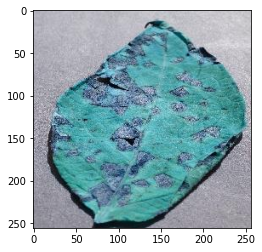

In [0]:
#img = image.load_img('/content/drive/My Drive/plantdisease/PlantVillage/Potato___Early_blight/042135e2-e126-4900-9212-d42d900b8125___RS_Early.B 8791.JPG', grayscale=False, target_size=(64, 64))
#show_img=image.load_img('/content/drive/My Drive/PlantVillage/Potato___Early_blight/042135e2-e126-4900-9212-d42d900b8125___RS_Early.B 8791.JPG', grayscale=False, target_size=(200, 200))
img=cv2.imread('/content/drive/My Drive/Plant_disease/PlantVillage/Potato___Early_blight/042135e2-e126-4900-9212-d42d900b8125___RS_Early.B 8791.JPG')
disease_class = ['Pepper__bell___Bacterial_spot','Pepper__bell___healthy','Potato___Early_blight','Potato___Late_blight','Potato___healthy','Tomato_Bacterial_spot','Tomato_Early_blight','Tomato_Late_blight','Tomato_Leaf_Mold','Tomato_Septoria_leaf_spot','Tomato_Spider_mites_Two_spotted_spider_mite','Tomato__Target_Spot','Tomato__Tomato_YellowLeaf__Curl_Virus','Tomato__Tomato_mosaic_virus','Tomato_healthy']
x = image.img_to_array(img)
x = resize_image(x,(64,64))
x = np.expand_dims(x, axis = 0)
##x = np.array(x, 'float32')
x /= 255

print (x.shape)
custom = model_from_h5.predict(x)
print (custom.argmax())
print (disease_class[custom.argmax()])
#print(custom[0])
#fig, ax = plt.subplots(2, 2, figsize=(12, 12))
plt.imshow(img)


Saving images.jpg to images (2).jpg
(1, 64, 64, 3)
9
Tomato_Septoria_leaf_spot


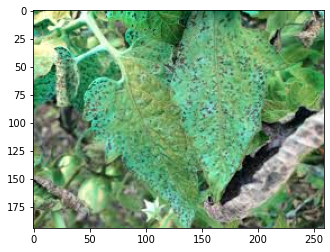

In [0]:
uploaded=files.upload()

for fn in uploaded.keys():
  path = '/content/' + fn
  img = cv2.imread(path)
  plt.imshow(img)
img=resize_image(img,(64,64))
img = np.expand_dims(img, axis = 0)
##x = np.array(x, 'float32')
img = img/255.

print (img.shape)
custom = model_from_h5.predict(img)
print (custom.argmax())
print (disease_class[custom.argmax()])

 
  # predicting images
#  path='/content/' + fn
#  img=image.load_img(path, target_size=(150, 150))
  
#  x=image.img_to_array(img)
#  x=np.expand_dims(x, axis=0)
#  images = np.vstack([x])
#  
#  classes = model.predict(images, batch_size=10)
  
#  print(classes[0])

Feature extraction in each layers of the model. In this particular case, visualisation may not be clear as there is thin line to differentiate different plants. However, distinction will be more profound in something like cat vs dog classification 

['conv2d_10', 'max_pooling2d_10', 'batch_normalization_7', 'conv2d_11', 'max_pooling2d_11', 'batch_normalization_8', 'conv2d_12', 'max_pooling2d_12', 'flatten_4', 'dense_10', 'dense_11']
conv2d_10
(1, 31, 31, 64)
max_pooling2d_10
(1, 31, 31, 64)
batch_normalization_7
(1, 29, 29, 32)
conv2d_11
(1, 14, 14, 32)
max_pooling2d_11
(1, 14, 14, 32)
batch_normalization_8
(1, 12, 12, 16)
conv2d_12
(1, 6, 6, 16)
max_pooling2d_12
(1, 576)
flatten_4
(1, 128)
dense_10
(1, 15)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in true_divide


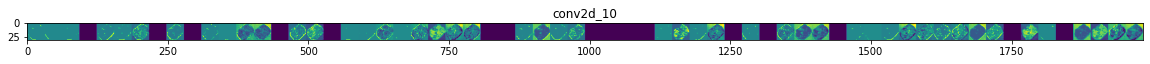

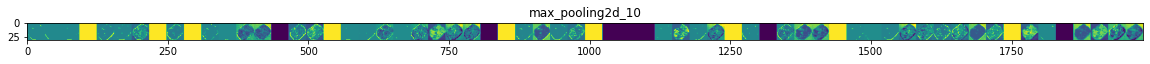

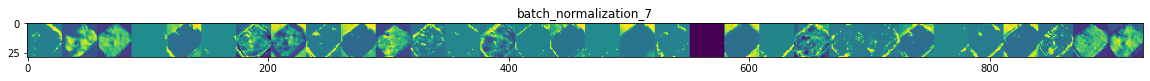

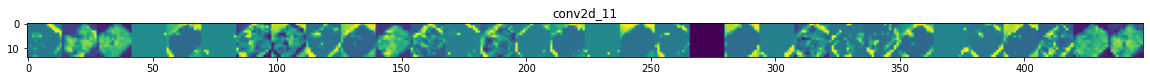

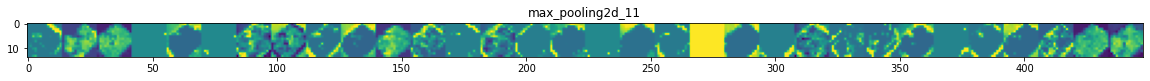

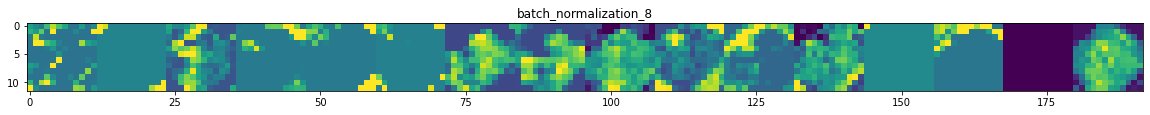

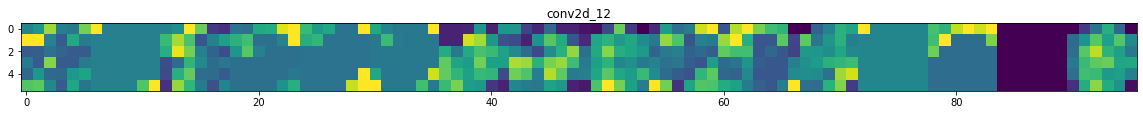

In [0]:
import numpy as np
import random
import tensorflow as tf
from   tensorflow.keras.preprocessing.image import img_to_array, load_img

# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model_from_h5.layers[1:]]

#print (successive_outputs)
#for layer in model_from_h5.layers:
#  print (layer.output)

##visualization_model = Model(img_input, successive_outputs)
visualization_model = Model(inputs = model_from_h5.input, outputs = successive_outputs)

#print (visualization_model)
# Let's prepare a random input image of a cat or dog from the training set.
#cat_img_files = [os.path.join(train_cats_dir, f) for f in train_cat_fnames]
#dog_img_files = [os.path.join(train_dogs_dir, f) for f in train_dog_fnames]
img=cv2.imread('/content/drive/My Drive/Plant_disease/PlantVillage/Potato___Early_blight/042135e2-e126-4900-9212-d42d900b8125___RS_Early.B 8791.JPG')
#img_path = random.choice(cat_img_files + dog_img_files)
#img = load_img(img_path, target_size=(150, 150))  # this is a PIL image
x = resize_image(img,(64,64))

#x = np.expand_dims(x, axis = 0)
##x = np.array(x, 'float32')
#x /= 255

#x   = img_to_array(img)                           # Numpy array with shape (150, 150, 3)
x   = x.reshape((1,) + x.shape)                   # Numpy array with shape (1, 150, 150, 3)
#print (x.shape)
# Rescale by 1/255
x = x/255.0

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)
#print (len(successive_feature_maps))
#print (successive_feature_maps[0])
#print (type(successive_feature_maps))
# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model_from_h5.layers]
print (layer_names)
#print (type(layer_names))
# -----------------------------------------------------------------------
# Now let's display our representations
# -----------------------------------------------------------------------
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  print (layer_name)
  print (feature_map.shape)
  
  if len(feature_map.shape) == 4:
    
    #-------------------------------------------
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    #-------------------------------------------
    n_features = feature_map.shape[-1]  # number of features in the feature map
    size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
    
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    
    #-------------------------------------------------
    # Postprocess the feature to be visually palatable
    #-------------------------------------------------
    for i in range(n_features):
      x  = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std ()
      x *=  64
      x += 128
      x  = np.clip(x, 0, 255).astype('uint8')
      display_grid[:, i * size : (i + 1) * size] = x # Tile each filter into a horizontal grid

    #-----------------
    # Display the grid
    #-----------------

    scale = 20. / n_features
    plt.figure( figsize=(scale * n_features, scale) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto', cmap='viridis' ) 

In [0]:
print (successive_feature_maps[0].shape,successive_feature_maps[1].shape, successive_feature_maps[2].shape )

(1, 31, 31, 64) (1, 31, 31, 64) (1, 29, 29, 32)


In [0]:
import numpy as np
import random
#import tensorflow as tf
from   tensorflow.keras.preprocessing.image import img_to_array, load_img

# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model_from_h5.layers[1:]]

#print (successive_outputs)
#for layer in model_from_h5.layers:
#  print (layer.output)

##visualization_model = Model(img_input, successive_outputs)
visualization_model = Model(inputs = model_from_h5.input, outputs = successive_outputs)

#print (visualization_model)
# Let's prepare a random input image of a cat or dog from the training set.
#cat_img_files = [os.path.join(train_cats_dir, f) for f in train_cat_fnames]
#dog_img_files = [os.path.join(train_dogs_dir, f) for f in train_dog_fnames]
img=cv2.imread('/content/drive/My Drive/Plant_disease/PlantVillage/Potato___Early_blight/042135e2-e126-4900-9212-d42d900b8125___RS_Early.B 8791.JPG')
#img_path = random.choice(cat_img_files + dog_img_files)
#img = load_img(img_path, target_size=(150, 150))  # this is a PIL image
x = resize_image(img,(64,64))

#x = np.expand_dims(x, axis = 0)
##x = np.array(x, 'float32')
#x /= 255

#x   = img_to_array(img)                           # Numpy array with shape (150, 150, 3)
x   = x.reshape((1,) + x.shape)                   # Numpy array with shape (1, 150, 150, 3)
#print (x.shape)
# Rescale by 1/255
x = x/255.0

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)
#print (len(successive_feature_maps))
#print (successive_feature_maps[0])
#print (type(successive_feature_maps))
# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model_from_h5.layers]
print (layer_names)

['conv2d_10', 'max_pooling2d_10', 'batch_normalization_7', 'conv2d_11', 'max_pooling2d_11', 'batch_normalization_8', 'conv2d_12', 'max_pooling2d_12', 'flatten_4', 'dense_10', 'dense_11']


In [0]:
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  print (layer_name)
  print (feature_map.shape)
print (layer_names[0])
print (successive_feature_maps[0].shape)

conv2d_10
(1, 31, 31, 64)
max_pooling2d_10
(1, 31, 31, 64)
batch_normalization_7
(1, 29, 29, 32)
conv2d_11
(1, 14, 14, 32)
max_pooling2d_11
(1, 14, 14, 32)
batch_normalization_8
(1, 12, 12, 16)
conv2d_12
(1, 6, 6, 16)
max_pooling2d_12
(1, 576)
flatten_4
(1, 128)
dense_10
(1, 15)
conv2d_10
(1, 31, 31, 64)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


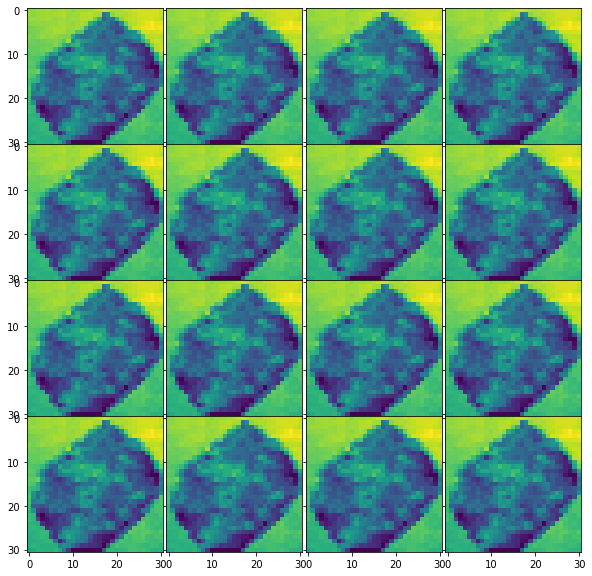

In [0]:
fig, axs = plt.subplots(4, 4,figsize=(10,10),sharex=True,sharey=True,gridspec_kw={'hspace': 0, 'wspace': 0})
for i in range(successive_feature_maps[0].shape[-1]):
  #print (i)
  x  = successive_feature_maps[0][0, :, :, i]
  #print (x.mean())
  x = x-x.mean()
  x = x/x.std ()
  x =  x*64
  x = x+128
  x  = np.clip(x, 0, 255).astype('uint8')
  for i in range(4):
    for j in range(4):
      axs[i,j].imshow(x)
  #print (x.mean())
#print (successive_feature_maps[0][0, :, :, 0])

**Conclusion:** It could be a good idea to import pre-defined model framework and initialize model with pre-trained weights. If we have sufficient number of dataset, creating a custom model could significantly reduce the number of trainable parameters and reduce the training time without affecting accuracy much. I was able to achieve almost comparable accuracy with relatively simple CNN model itself.